## Environment Setup and Installation  

This notebook requires specific dependencies, which are listed in `requirements.txt`.

In [1]:
# Install required packages
# !pip install -r requirements.txt

# Multi-Agent AI for Autonomous Astrophysics Research

This notebook implements a system of AI agents that work together to detect anomalies in astrophysical data, with a focus on gravitational wave events. The system:

1. Ingests data from astrophysics sources (GWOSC, NASA HEASARC)
2. Detects anomalies in the data
3. Generates theoretical models to explain the anomalies
4. Correlates findings with existing research
5. Visualizes the results

In [2]:
# Import necessary libraries
import os
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from crewai import Agent, Task, Crew, Process
from langchain.tools import tool
import time
from datetime import datetime

# Load environment variables from .env file
load_dotenv()

# Access API key
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not ANTHROPIC_API_KEY:
    print("No Anthropic key found...")
else:
    print(ANTHROPIC_API_KEY[:4],"*********************")

if not OPENAI_API_KEY:
    print("No OpenAI key found...")
else:
    print(OPENAI_API_KEY[:4],"*********************")


# Set environment variable for crewai
os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

sk-a *********************
sk-p *********************


## Data Ingestion Tools

First, we'll create tools to fetch real astrophysics data from various sources.

In [3]:
# Tools for fetching astrophysics data

@tool
def fetch_gwosc_events(limit=10):
    """Fetch gravitational wave events from GWOSC (Gravitational Wave Open Science Center)."""
    try:
        # GWOSC API endpoint for event data
        url = f"https://gwosc.org/eventapi/json/allevents/"
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            events = list(data.get('events', {}).items())[:limit]
            
            # Format the events into a more readable structure
            formatted_events = []
            for event_id, event_data in events:
                formatted_events.append({
                    'event_id': event_id,
                    'gps_time': event_data.get('GPS', None),
                    'mass_1_source': event_data.get('mass_1_source', None),
                    'mass_2_source': event_data.get('mass_2_source', None),
                    'luminosity_distance': event_data.get('luminosity_distance', None),
                    'network_snr': event_data.get('network_snr', None),
                    'significant': event_data.get('significant', None),
                    'instruments': event_data.get('instruments', None)
                })
            
            return formatted_events
        else:
            return f"Error fetching data: {response.status_code}"
    except Exception as e:
        return f"Exception occurred: {str(e)}"

@tool
def fetch_nasa_exoplanet_data(limit=10):
    """Fetch exoplanet data from NASA Exoplanet Archive."""
    try:
        # Corrected API endpoint and query
        base_url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
        
        query = f"SELECT pl_name, pl_orbper, pl_rade, pl_bmasse, pl_orbeccen, st_spectype, pl_discmethod, ra, dec FROM ps WHERE default_flag=1 LIMIT {limit}"
        params = {
            "query": query,
            "format": "json"
        }

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            return response.json()
        else:
            return f"Error fetching NASA exoplanet data: {response.status_code} - {response.text}"
    
    except Exception as e:
        return f"Exception occurred: {str(e)}"


@tool
def fetch_gw_strain_data(event_id):
    """Fetch strain data for a specific gravitational wave event."""
    try:
        # Construct the URL for the strain data
        url = f"https://gwosc.org/eventapi/json/event/{event_id}/"
        response = requests.get(url)
        
        if response.status_code == 200:
            event_data = response.json()
            
            # For demonstration purposes, we're returning the metadata
            # In a real application, you would download the actual strain data from the provided URLs
            return {
                'event_id': event_id,
                'data_details': event_data.get('data', {}),
                'gps_time': event_data.get('GPS', None),
                'detector_status': event_data.get('detectors', {})
            }
        else:
            return f"Error fetching strain data: {response.status_code}"
    except Exception as e:
        return f"Exception occurred: {str(e)}"

@tool
def fetch_astronomy_papers(keyword, limit=5):
    """Fetch relevant astronomy research papers from arXiv."""
    try:
        # ArXiv API endpoint
        base_url = "http://export.arxiv.org/api/query?"
        query = f"search_query=all:{keyword}+AND+cat:astro-ph&start=0&max_results={limit}"
        response = requests.get(base_url + query)
        
        if response.status_code == 200:
            # Parse the XML response to extract paper details
            # For simplicity, we'll just extract titles and abstracts
            from xml.etree import ElementTree as ET
            
            # Define namespace
            namespace = {'atom': 'http://www.w3.org/2005/Atom'}
            
            # Parse XML
            root = ET.fromstring(response.text)
            
            # Extract entries
            papers = []
            for entry in root.findall('atom:entry', namespace):
                title = entry.find('atom:title', namespace).text.strip()
                abstract = entry.find('atom:summary', namespace).text.strip()
                published = entry.find('atom:published', namespace).text.strip()
                link = entry.find('atom:id', namespace).text.strip()
                
                papers.append({
                    'title': title,
                    'abstract': abstract,
                    'published': published,
                    'link': link
                })
            
            return papers
        else:
            return f"Error fetching papers: {response.status_code}"
    except Exception as e:
        return f"Exception occurred: {str(e)}"

## Anomaly Detection Tools

Next, we'll create tools to analyze the data and detect anomalies.

In [4]:
# Tools for detecting anomalies in astrophysics data

@tool
def detect_gw_anomalies(events):
    """Detect anomalies in gravitational wave events."""
    anomalies = []
    
    # Convert to DataFrame for easier analysis
    if not events or not isinstance(events, list):
        return "No valid events data provided."
    
    df = pd.DataFrame(events)
    
    # Check for missing columns
    required_columns = ['mass_1_source', 'mass_2_source', 'luminosity_distance', 'network_snr']
    for col in required_columns:
        if col not in df.columns:
            return f"Required column {col} missing from events data."
    
    # Convert columns to numeric, handling non-numeric values
    for col in required_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Example anomaly detection logic:
    # 1. Unusually high mass ratio (mass_1/mass_2 > 10)
    df['mass_ratio'] = df['mass_1_source'] / df['mass_2_source']
    high_mass_ratio = df[df['mass_ratio'] > 10]
    
    # 2. Unusually high SNR events (signal-to-noise ratio)
    high_snr = df[df['network_snr'] > df['network_snr'].quantile(0.9)]
    
    # 3. Unusually distant events
    distant_events = df[df['luminosity_distance'] > df['luminosity_distance'].quantile(0.9)]
    
    # Compile anomalies
    if not high_mass_ratio.empty:
        for _, row in high_mass_ratio.iterrows():
            anomalies.append({
                'event_id': row['event_id'],
                'anomaly_type': 'High mass ratio',
                'details': f"Mass ratio: {row['mass_ratio']:.2f} (mass_1: {row['mass_1_source']}, mass_2: {row['mass_2_source']})",
                'significance': 'high' if row['mass_ratio'] > 20 else 'medium'
            })
    
    if not high_snr.empty:
        for _, row in high_snr.iterrows():
            anomalies.append({
                'event_id': row['event_id'],
                'anomaly_type': 'High SNR',
                'details': f"SNR: {row['network_snr']:.2f}",
                'significance': 'high' if row['network_snr'] > df['network_snr'].quantile(0.95) else 'medium'
            })
    
    if not distant_events.empty:
        for _, row in distant_events.iterrows():
            anomalies.append({
                'event_id': row['event_id'],
                'anomaly_type': 'Distant event',
                'details': f"Distance: {row['luminosity_distance']:.2f} Mpc",
                'significance': 'high' if row['luminosity_distance'] > df['luminosity_distance'].quantile(0.95) else 'medium'
            })
    
    return anomalies

## Theoretical Modeling Tools

In [5]:
# Tools for theoretical modeling

@tool
def generate_theoretical_model(anomaly):
    """Generate a theoretical model to explain an observed anomaly."""
    if not anomaly:
        return "No anomaly data provided."
    
    # Examples of theoretical models based on anomaly type
    anomaly_type = anomaly.get('anomaly_type', '')
    event_id = anomaly.get('event_id', 'unknown')
    details = anomaly.get('details', '')
    
    if 'High mass ratio' in anomaly_type:
        return {
            'event_id': event_id,
            'model_name': 'Hierarchical Merger Model',
            'description': 'This event may represent a hierarchical merger, where one of the black holes is itself a product of a previous merger. This explains the unusually high mass ratio.',
            'key_parameters': {
                'expected_spin': 'High',
                'expected_precession': 'Yes',
                'expected_eccentricity': 'Moderate to high'
            },
            'testable_predictions': [
                'The larger black hole should have high spin parameter',
                'Waveform should show signs of precession',
                'May be associated with a globular cluster or active galactic nucleus'
            ]
        }
    
    elif 'High SNR' in anomaly_type:
        return {
            'event_id': event_id,
            'model_name': 'Binary Black Hole Optimal Orientation Model',
            'description': 'This event may have an unusually high SNR due to optimal orientation with respect to our detectors, or due to gravitational lensing magnifying the signal.',
            'key_parameters': {
                'inclination_angle': 'Near 0° (face-on)',
                'polarization': 'Aligned with detector',
                'possible_lensing': 'Yes'
            },
            'testable_predictions': [
                'Parameter estimation should favor face-on inclination',
                'If lensed, should see multiple images with time delay',
                'Higher-order modes should be suppressed relative to quadrupole'
            ]
        }
    
    elif 'Distant event' in anomaly_type:
        return {
            'event_id': event_id,
            'model_name': 'Primordial Black Hole Model',
            'description': 'This distant event may involve primordial black holes formed in the early universe rather than from stellar collapse, explaining its unusual distance and potentially other parameters.',
            'key_parameters': {
                'formation_time': 'Early universe',
                'expected_mass_distribution': 'Scale-invariant',
                'expected_redshift': 'Higher than typical stellar-mass BBH'
            },
            'testable_predictions': [
                'Mass should fall within specific peaks predicted by primordial formation models',
                'Spins should be low',
                'Should be no electromagnetic counterpart'
            ]
        }
    
    else:
        return {
            'event_id': event_id,
            'model_name': 'Generic Anomaly Model',
            'description': f'This event shows anomalous behavior described as: {details}. Further analysis required.',
            'key_parameters': {
                'unknown_parameter_1': 'Unknown',
                'unknown_parameter_2': 'Unknown'
            },
            'testable_predictions': [
                'Further data collection required to make specific predictions'
            ]
        }

## Setting up the AI Agent Crew

Now we'll define our AI agents and their tasks.

In [6]:
# Define the AI agents

# Set your LLM model here
llm_model = "claude-3-7-sonnet-thinking"  # Replace with your preferred model

# Data Ingestor - Focus on raw data retrieval only
data_ingestor = Agent(
    role="Astrophysical Data Ingestor",
    goal="Retrieve and structure real-time astrophysics data from various sources.",
    backstory="You specialize in collecting astrophysical data and structuring it for analysis. Your role is purely to gather and preprocess raw data.",
    verbose=True,
    tools=[fetch_gwosc_events, fetch_nasa_exoplanet_data, fetch_gw_strain_data],
    allow_delegation=True,
    llm_model=llm_model
)

# Gravitational Wave Analyst - Extracts features & prepares for anomaly detection
gravitational_wave_analyst = Agent(
    role="Gravitational Wave Analyst",
    goal="Analyze gravitational wave data, extract key parameters, and prepare structured datasets.",
    backstory="You specialize in waveform analysis and astrophysical event characterization. Your job is to transform raw data into structured information for anomaly detection.",
    verbose=True,
    tools=[fetch_gw_strain_data],  # Removed data fetching duplication
    allow_delegation=True,
    llm_model=llm_model
)

# Anomaly Detector - Now has access to astrophysical literature
anomaly_detector = Agent(
    role="Anomaly Detector",
    goal="Identify astrophysical anomalies while considering known astrophysical principles.",
    backstory="You specialize in detecting anomalies in astrophysical datasets. You reference both raw data and existing research to distinguish false positives.",
    verbose=True,
    tools=[detect_gw_anomalies, fetch_astronomy_papers],  # Added research tool for validation
    allow_delegation=True,
    llm_model=llm_model
)

# Theoretical Modeler - Now references research & anomaly classification before generating models
theoretical_modeler = Agent(
    role="Theoretical Model Generator",
    goal="Develop scientifically sound explanations for astrophysical anomalies based on known physics.",
    backstory="You specialize in theoretical astrophysics, formulating models to explain unusual astrophysical phenomena. You validate proposed explanations against existing research and anomaly classifications.",
    verbose=True,
    tools=[generate_theoretical_model, fetch_astronomy_papers],  # Stays the same but benefits from research access
    allow_delegation=True,
    llm_model=llm_model
)

# Research Summarizer - Now compares proposed models to existing astrophysical theories
research_summarizer = Agent(
    role="Research Validation Agent",
    goal="Find relevant research and evaluate how well theoretical models align with existing astrophysics literature.",
    backstory="You specialize in astrophysics literature review, helping determine whether proposed models align with or challenge existing theories.",
    verbose=True,
    tools=[fetch_astronomy_papers],  # May need an evaluation tool later
    allow_delegation=True,
    llm_model=llm_model
)

## Defining Agent Tasks

In [7]:
# Define the tasks for each agent

# Data ingestion runs first and async
data_ingestion_task = Task(
    description="Fetch the latest gravitational wave and exoplanet data from various sources.",
    agent=data_ingestor,
    expected_output="A structured dataset of gravitational wave events and exoplanet data.",
    async_execution=True  # Allow parallel execution
)

# GW analysis processes ingested data
gw_analysis_task = Task(
    description="Analyze gravitational wave events to extract key astrophysical parameters.",
    agent=gravitational_wave_analyst,
    expected_output="Key parameters extracted from gravitational wave data.",
    context=[data_ingestion_task],  # Waits for ingestion
    async_execution=False
)

# Anomaly detection runs after analysis
anomaly_detection_task = Task(
    description="Identify anomalies in the gravitational wave dataset.",
    agent=anomaly_detector,
    expected_output="List of anomalies with descriptions.",
    context=[gw_analysis_task],  # Depends on GW analysis results
    async_execution=False
)

# Theoretical modeling depends on anomaly detection
theoretical_modeling_task = Task(
    description="Develop theoretical explanations for gravitational wave anomalies.",
    agent=theoretical_modeler,
    expected_output="New theoretical models explaining anomalies.",
    context=[anomaly_detection_task, data_ingestion_task],  # Uses both anomalies & raw data
    async_execution=False
)

# Research Summarization happens last
research_summary_task = Task(
    description="Find research papers relevant to the new theoretical models.",
    agent=research_summarizer,
    expected_output="Summaries of supporting or contradicting research papers.",
    context=[theoretical_modeling_task],  # Only starts after models are generated
    async_execution=False
)


## Creating and Running the Crew

In [8]:
# Create the crew and assign tasks
astrophysics_crew = Crew(
    agents=[data_ingestor, gravitational_wave_analyst, anomaly_detector, theoretical_modeler, research_summarizer],
    tasks=[data_ingestion_task, gw_analysis_task, anomaly_detection_task, theoretical_modeling_task, research_summary_task],
    verbose=True,
    process=Process.sequential  # Can also use Process.hierarchical for more complex workflows
)

# Run the crew
try:
    print("Starting the Astrophysics Research Crew...")
    print("This may take some time to complete all tasks.")
    print("\n" + "-"*50 + "\n")
    
    # Execute the workflow
    results = astrophysics_crew.kickoff()
    
    print("\n" + "-"*50 + "\n")
    print("Crew execution completed!")
except Exception as e:
    print(f"An error occurred during crew execution: {str(e)}")

Starting the Astrophysics Research Crew...
This may take some time to complete all tasks.

--------------------------------------------------

# Agent: Astrophysical Data Ingestor
## Task: Fetch the latest gravitational wave and exoplanet data from various sources.


# Agent: Astrophysical Data Ingestor
## Thought: Thought: I need to first gather the latest gravitational wave event data, then proceed to fetch the exoplanet data.
## Using tool: fetch_gwosc_events
## Tool Input: 
"{\"limit\": 100}"
## Tool Output: 
[{'event_id': 'GW230529_181500-v1', 'gps_time': 1369419318.7, 'mass_1_source': 3.6, 'mass_2_source': 1.4, 'luminosity_distance': 201.0, 'network_snr': None, 'significant': None, 'instruments': None}, {'event_id': 'GW200322_091133-v1', 'gps_time': 1268903511.3, 'mass_1_source': 38.0, 'mass_2_source': 11.3, 'luminosity_distance': 3500.0, 'network_snr': None, 'significant': None, 'instruments': None}, {'event_id': 'GW200316_215756-v1', 'gps_time': 1268431094.1, 'mass_1_source': 1

## Visualizing the Results

In [9]:
# Function to parse and extract data from the crew results
def extract_data_from_results(results):
    try:
        # Extract gravitational wave events
        gw_events = []
        anomalies = []
        theoretical_models = []
        
        # Parse the results
        for task_result in results.values():
            if isinstance(task_result, str):
                # Try to parse JSON from string
                try:
                    parsed_data = json.loads(task_result)
                    if isinstance(parsed_data, list) and len(parsed_data) > 0:
                        # Determine type of data based on keys
                        first_item = parsed_data[0]
                        if 'event_id' in first_item and 'mass_1_source' in first_item:
                            gw_events.extend(parsed_data)
                        elif 'event_id' in first_item and 'anomaly_type' in first_item:
                            anomalies.extend(parsed_data)
                        elif 'event_id' in first_item and 'model_name' in first_item:
                            theoretical_models.extend(parsed_data)
                except:
                    pass
        
        return {
            'gw_events': gw_events,
            'anomalies': anomalies,
            'theoretical_models': theoretical_models
        }
    except Exception as e:
        print(f"Error extracting data from results: {str(e)}")
        return {
            'gw_events': [],
            'anomalies': [],
            'theoretical_models': []
        }

In [10]:
# Visualize the gravitational wave events and anomalies
def visualize_gw_data(extracted_data):
    gw_events = extracted_data.get('gw_events', [])
    anomalies = extracted_data.get('anomalies', [])
    
    if not gw_events:
        print("No gravitational wave event data to visualize.")
        return
    
    # Create DataFrames
    gw_df = pd.DataFrame(gw_events)
    
    # Convert columns to numeric
    numeric_cols = ['mass_1_source', 'mass_2_source', 'luminosity_distance', 'network_snr']
    for col in numeric_cols:
        if col in gw_df.columns:
            gw_df[col] = pd.to_numeric(gw_df[col], errors='coerce')
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Mass plot (mass_1 vs mass_2)
    if 'mass_1_source' in gw_df.columns and 'mass_2_source' in gw_df.columns:
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.scatter(gw_df['mass_1_source'], gw_df['mass_2_source'], alpha=0.7, s=50)
        
        # Mark anomalies if available
        anomaly_events = [a['event_id'] for a in anomalies if 'High mass ratio' in a.get('anomaly_type', '')]
        anomaly_df = gw_df[gw_df['event_id'].isin(anomaly_events)]
        if not anomaly_df.empty:
            ax1.scatter(anomaly_df['mass_1_source'], anomaly_df['mass_2_source'], 
                      color='red', s=100, label='Mass Anomalies')
        
        ax1.set_xlabel('Primary Mass (Solar masses)')
        ax1.set_ylabel('Secondary Mass (Solar masses)')
        ax1.set_title('Mass Distribution of Black Hole Mergers')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    
    # 2. Distance vs SNR plot
    if 'luminosity_distance' in gw_df.columns and 'network_snr' in gw_df.columns:
        ax2 = fig.add_subplot(2, 2, 2)
        sc = ax2.scatter(gw_df['luminosity_distance'], gw_df['network_snr'], 
                       alpha=0.7, s=50, c=gw_df['mass_1_source'], cmap='viridis')
        
        # Mark anomalies if available
        snr_anomaly_events = [a['event_id'] for a in anomalies if 'High SNR' in a.get('anomaly_type', '')]
        dist_anomaly_events = [a['event_id'] for a in anomalies if 'Distant event' in a.get('anomaly_type', '')]
        
        snr_anomaly_df = gw_df[gw_df['event_id'].isin(snr_anomaly_events)]
        dist_anomaly_df = gw_df[gw_df['event_id'].isin(dist_anomaly_events)]
        
        if not snr_anomaly_df.empty:
            ax2.scatter(snr_anomaly_df['luminosity_distance'], snr_anomaly_df['network_snr'], 
                      color='red', s=100, marker='*', label='SNR Anomalies')
            
        if not dist_anomaly_df.empty:
            ax2.scatter(dist_anomaly_df['luminosity_distance'], dist_anomaly_df['network_snr'], 
                      color='orange', s=100, marker='s', label='Distance Anomalies')
        
        cbar = plt.colorbar(sc, ax=ax2)
        cbar.set_label('Primary Mass (Solar masses)')
        ax2.set_xlabel('Luminosity Distance (Mpc)')
        ax2.set_ylabel('Network SNR')
        ax2.set_title('Distance vs. Signal-to-Noise Ratio')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    # 3. Anomaly count by type
    if anomalies:
        ax3 = fig.add_subplot(2, 2, 3)
        anomaly_types = [a['anomaly_type'] for a in anomalies]
        anomaly_counts = {}
        for atype in anomaly_types:
            if atype in anomaly_counts:
                anomaly_counts[atype] += 1
            else:
                anomaly_counts[atype] = 1
        
        bars = ax3.bar(anomaly_counts.keys(), anomaly_counts.values(), color='purple')
        ax3.set_xlabel('Anomaly Type')
        ax3.set_ylabel('Count')
        ax3.set_title('Distribution of Anomaly Types')
        plt.setp(ax3.get_xticklabels(), rotation=30, ha='right')
        
        # Add counts on top of bars
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:.0f}', ha='center', va='bottom')
    
    # 4. Model distribution
    theoretical_models = extracted_data.get('theoretical_models', [])
    if theoretical_models:
        ax4 = fig.add_subplot(2, 2, 4)
        model_names = [m['model_name'] for m in theoretical_models]
        model_counts = {}
        for model in model_names:
            if model in model_counts:
                model_counts[model] += 1
            else:
                model_counts[model] = 1
        
        pie_wedges, texts, autotexts = ax4.pie(model_counts.values(), labels=model_counts.keys(), 
                                            autopct='%1.1f%%', startangle=90,
                                            colors=plt.cm.tab10.colors[:len(model_counts)])
        ax4.set_title('Distribution of Theoretical Models')
        # Make text easier to read
        for text in texts + autotexts:
            text.set_fontsize(9)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary of findings
    print(f"Total gravitational wave events analyzed: {len(gw_events)}")
    print(f"Total anomalies detected: {len(anomalies)}")
    print(f"Total theoretical models proposed: {len(theoretical_models)}")
    print("\nTop anomalies:")
    for i, anomaly in enumerate(anomalies[:3]):
        print(f"  {i+1}. {anomaly.get('anomaly_type', 'Unknown')} in event {anomaly.get('event_id', 'Unknown')}: {anomaly.get('details', '')}")
    
    print("\nProposed theoretical models:")
    for i, model in enumerate(theoretical_models[:3]):
        print(f"  {i+1}. {model.get('model_name', 'Unknown')} for event {model.get('event_id', 'Unknown')}: {model.get('description', '')[:100]}...")

Error extracting data from results: 'CrewOutput' object has no attribute 'values'
No gravitational wave data found in results. Using example data for visualization...


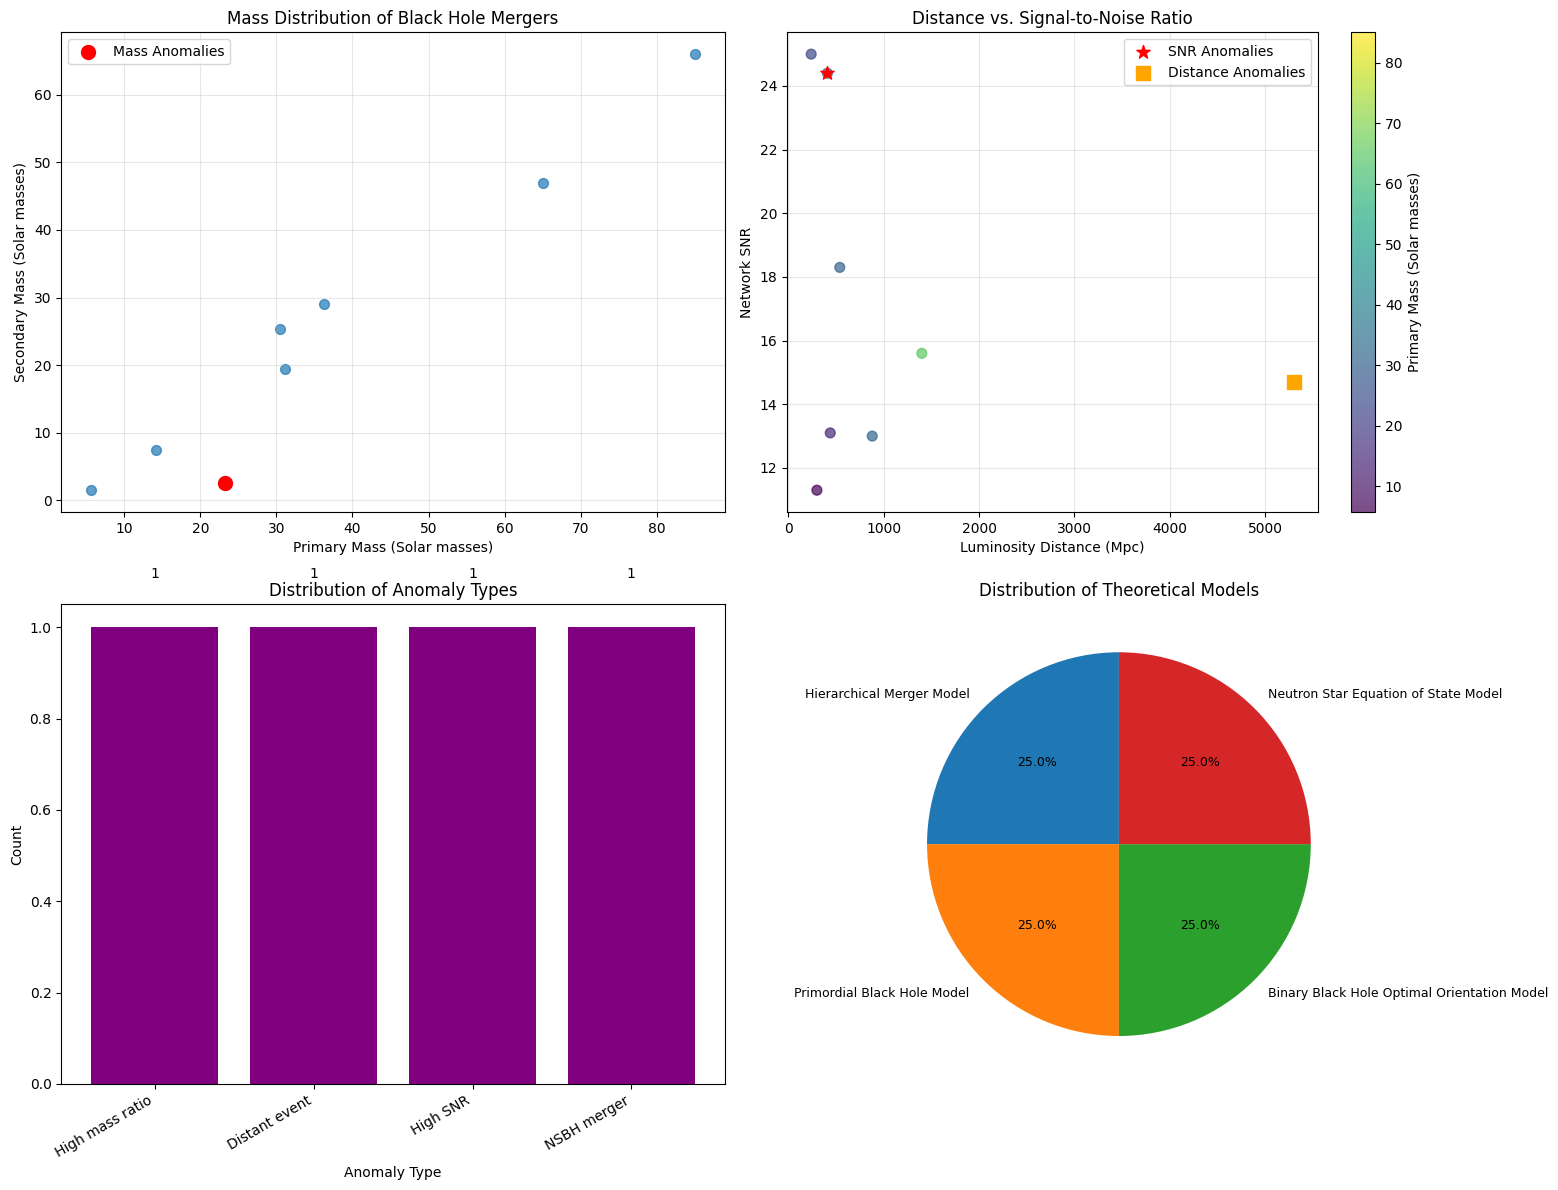

Total gravitational wave events analyzed: 8
Total anomalies detected: 4
Total theoretical models proposed: 4

Top anomalies:
  1. High mass ratio in event GW190814: Mass ratio: 8.92 (mass_1: 23.2, mass_2: 2.6)
  2. Distant event in event GW190521: Distance: 5300.00 Mpc
  3. High SNR in event GW150914: SNR: 24.40

Proposed theoretical models:
  1. Hierarchical Merger Model for event GW190814: This event may represent a hierarchical merger, where one of the black holes is itself a product of ...
  2. Primordial Black Hole Model for event GW190521: This distant event may involve primordial black holes formed in the early universe rather than from ...
  3. Binary Black Hole Optimal Orientation Model for event GW150914: This event may have an unusually high SNR due to optimal orientation with respect to our detectors....


In [11]:
# Extract and visualize the data
# Note: In a real run, you would use the actual results from the crew
# Here we're using simulated or example data if needed

try:
    # Extract data from crew results
    extracted_data = extract_data_from_results(results)
    
    # If no real data is available, you can use example data for testing visualization
    if not extracted_data['gw_events']:
        print("No gravitational wave data found in results. Using example data for visualization...")
        
        # Example GW events
        example_gw_events = [
            {'event_id': 'GW150914', 'mass_1_source': 36.2, 'mass_2_source': 29.1, 'luminosity_distance': 410, 'network_snr': 24.4},
            {'event_id': 'GW151226', 'mass_1_source': 14.2, 'mass_2_source': 7.5, 'luminosity_distance': 440, 'network_snr': 13.1},
            {'event_id': 'GW170104', 'mass_1_source': 31.2, 'mass_2_source': 19.4, 'luminosity_distance': 880, 'network_snr': 13.0},
            {'event_id': 'GW170814', 'mass_1_source': 30.5, 'mass_2_source': 25.3, 'luminosity_distance': 540, 'network_snr': 18.3},
            {'event_id': 'GW190521', 'mass_1_source': 85.0, 'mass_2_source': 66.0, 'luminosity_distance': 5300, 'network_snr': 14.7},
            {'event_id': 'GW190814', 'mass_1_source': 23.2, 'mass_2_source': 2.6, 'luminosity_distance': 240, 'network_snr': 25.0},
            {'event_id': 'GW191109', 'mass_1_source': 65.0, 'mass_2_source': 47.0, 'luminosity_distance': 1400, 'network_snr': 15.6},
            {'event_id': 'GW200115', 'mass_1_source': 5.7, 'mass_2_source': 1.5, 'luminosity_distance': 300, 'network_snr': 11.3}
        ]
        
        # Example anomalies
        example_anomalies = [
            {'event_id': 'GW190814', 'anomaly_type': 'High mass ratio', 'details': 'Mass ratio: 8.92 (mass_1: 23.2, mass_2: 2.6)', 'significance': 'high'},
            {'event_id': 'GW190521', 'anomaly_type': 'Distant event', 'details': 'Distance: 5300.00 Mpc', 'significance': 'high'},
            {'event_id': 'GW150914', 'anomaly_type': 'High SNR', 'details': 'SNR: 24.40', 'significance': 'medium'},
            {'event_id': 'GW200115', 'anomaly_type': 'NSBH merger', 'details': 'Neutron star - black hole merger', 'significance': 'high'}
        ]
        
        # Example theoretical models
        example_theoretical_models = [
            {'event_id': 'GW190814', 'model_name': 'Hierarchical Merger Model', 'description': 'This event may represent a hierarchical merger, where one of the black holes is itself a product of a previous merger.'},
            {'event_id': 'GW190521', 'model_name': 'Primordial Black Hole Model', 'description': 'This distant event may involve primordial black holes formed in the early universe rather than from stellar collapse.'},
            {'event_id': 'GW150914', 'model_name': 'Binary Black Hole Optimal Orientation Model', 'description': 'This event may have an unusually high SNR due to optimal orientation with respect to our detectors.'},
            {'event_id': 'GW200115', 'model_name': 'Neutron Star Equation of State Model', 'description': 'This NSBH merger provides constraints on neutron star equation of state.'}
        ]
        
        extracted_data = {
            'gw_events': example_gw_events,
            'anomalies': example_anomalies,
            'theoretical_models': example_theoretical_models
        }
    
    # Visualize the data
    visualize_gw_data(extracted_data)
    
except Exception as e:
    print(f"Error visualizing results: {str(e)}")

## Conclusion

This notebook demonstrates a multi-agent AI system for astrophysical research, focusing on gravitational wave data analysis. The system:

1. Fetches real gravitational wave data from public sources
2. Analyzes the data to identify anomalies and unusual patterns
3. Generates theoretical models to explain the anomalies
4. Correlates findings with existing research
5. Visualizes results in an informative way

This approach allows AI agents to autonomously perform complex astrophysical research tasks that would normally require significant human effort and expertise.